In [4]:
%matplotlib inline

import time

import keras
from keras.utils.np_utils import to_categorical
from keras.utils import plot_model

import subprocess as sp
import numpy as np

from models import ZMlpClassifier, ZCnnClassifier
from models import PatchedKerasClassifier

from patch._sklearn import cross_val_score, get_learning_curve
from utils import load_keras_dataset, concat_sample

from utils import visualize_feature, down_sampling
from callbacks import FeedforwardHistory
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.ioff()
# plt.rcParams['font.family'] = 'Droid Sans Fallback'   # support zh-chinese


# Cifar10

In [2]:
dataset_name = 'cifar10'
(x_train, y_train), (x_test, y_test), (input_shape, num_classes) = load_keras_dataset(dataset_name, model_type='cnn')
x_all, y_all = concat_sample((x_train, x_test), (y_train, y_test))

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


In [7]:
# y shape patch
y_all = y_all[:, 0]

# Learning Curve

In [11]:
%%time
t_start = time.time()
penalty = (0.0, 0.03)
sigma = (0.0, 0.01)
colors = (('purple', 'red'), ('green', 'blue'))
markers = (('o--', 'o--'), ('o-', 'o-'))
epochs = 50
latent_dim = 32
activation = 'relu'
train_points = 2
batch_size = 128
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

fig = plt.figure(figsize=(18, 10))
ax = fig.gca()

build_fn = ZCnnClassifier(input_shape, num_classes,
                          activation=activation, latent_dim=latent_dim,
                          vi_penalty=penalty[0], sigma=sigma[0])

estimator = PatchedKerasClassifier(build_fn=build_fn, epochs=epochs, batch_size=batch_size, verbose=0)
_, ax = get_learning_curve(ax, estimator,
                           np.linspace(0.1, 1.0, train_points),
                           x_all, dict(classifier=y_all, decoder=x_all), cv=cv, marker_pair=markers[0],
                           label_meta='p: {}/s: {}'.format(penalty[0], sigma[0]), color_pair=colors[0])

build_fn = ZCnnClassifier(input_shape, num_classes,
                          activation=activation, latent_dim=latent_dim,
                          vi_penalty=penalty[1], sigma=sigma[1])

estimator = PatchedKerasClassifier(build_fn=build_fn, epochs=epochs, batch_size=batch_size, verbose=0)
_, ax = get_learning_curve(ax, estimator,
                           np.linspace(0.1, 1.0, train_points),
                           x_all, dict(classifier=y_all, decoder=x_all), cv=cv, marker_pair=markers[1],
                           label_meta='p: {}/s: {}'.format(penalty[1], sigma[1]), color_pair=colors[1])

ax.set_title('Learning Curve\n{}:{}'.format(dataset_name, build_fn.__name__))
plt.close(fig)

t_end = time.time()
t_diff = t_end - t_start

CPU times: user 1h 21min 12s, sys: 11min 16s, total: 1h 32min 28s
Wall time: 52min 21s


In [12]:
t_diff / 60

52.361688792705536

In [ ]:
# fig.savefig('data/{}/learning_curve.{}.png'.format(dataset_name, build_fn.__name__))

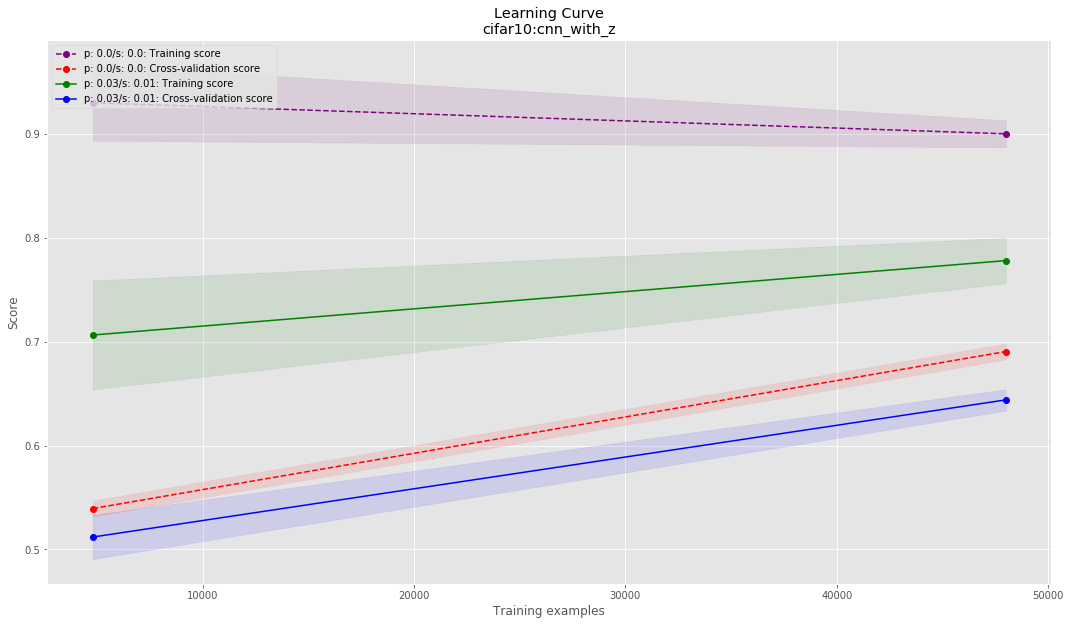

In [13]:
# latent_dim = 32
display(fig)

# Latent space visualization

In [54]:
penalty = 0.03
sigma = 0.01
colors = (('purple', 'red'), ('green', 'blue'))
markers = (('o--', 'o--'), ('o-', 'o-'))
epochs = 30
latent_dim = 16
activation = 'relu'
train_points = 5
batch_size = 128


x_sub, y_sub = down_sampling(x_test, y_test)
build_fn = ZCnnClassifier(input_shape, num_classes,
                          activation=activation,
                          latent_dim=latent_dim, vi_penalty=penalty, sigma=sigma)
model = build_fn(do_compile=False)

encoder = build_fn.getnet('encoder')
# decoder = build_fn.getnet('decoder')
# for l in decoder.layers: 
#     l.trainable = False

latent_history = FeedforwardHistory(encoder, x_sub, skip=50)
model = build_fn.compile(model)

CPU times: user 132 ms, sys: 0 ns, total: 132 ms
Wall time: 130 ms


In [55]:
%%time
history = model.fit(x_train,
                    dict(classifier=to_categorical(y_train), decoder=x_train),
                    batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[latent_history])

Epoch 1/30
 1152/60000 [..............................] - ETA: 8:11 - loss: 6.2239 - classifier_loss: 2.2357 - decoder_loss: 3.9882 - classifier_acc: 0.1780 - decoder_acc: 0.2996 

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (1.567503). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 19s 319us/step - loss: 2.6067 - classifier_loss: 0.7311 - decoder_loss: 1.8756 - classifier_acc: 0.7736 - decoder_acc: 0.4921
Epoch 2/30
 1280/60000 [..............................] - ETA: 13s - loss: 1.7775 - classifier_loss: 0.4886 - decoder_loss: 1.2889 - classifier_acc: 0.8516 - decoder_acc: 0.5007

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103668). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 10s 162us/step - loss: 1.6091 - classifier_loss: 0.4574 - decoder_loss: 1.1517 - classifier_acc: 0.8618 - decoder_acc: 0.5030
Epoch 3/30
 1280/60000 [..............................] - ETA: 13s - loss: 1.4749 - classifier_loss: 0.4137 - decoder_loss: 1.0613 - classifier_acc: 0.8703 - decoder_acc: 0.5083

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106498). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 10s 161us/step - loss: 1.3868 - classifier_loss: 0.3890 - decoder_loss: 0.9978 - classifier_acc: 0.8809 - decoder_acc: 0.5035
Epoch 4/30
 1280/60000 [..............................] - ETA: 13s - loss: 1.2902 - classifier_loss: 0.3686 - decoder_loss: 0.9216 - classifier_acc: 0.8922 - decoder_acc: 0.5013

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107675). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 10s 163us/step - loss: 1.2601 - classifier_loss: 0.3473 - decoder_loss: 0.9128 - classifier_acc: 0.8927 - decoder_acc: 0.50385s - loss: 1.2879 - cl
Epoch 5/30
 1280/60000 [..............................] - ETA: 13s - loss: 1.1983 - classifier_loss: 0.3062 - decoder_loss: 0.8921 - classifier_acc: 0.9102 - decoder_acc: 0.5081

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108857). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 10s 162us/step - loss: 1.1737 - classifier_loss: 0.3185 - decoder_loss: 0.8552 - classifier_acc: 0.9006 - decoder_acc: 0.5041
Epoch 6/30
 1280/60000 [..............................] - ETA: 13s - loss: 1.1282 - classifier_loss: 0.2934 - decoder_loss: 0.8347 - classifier_acc: 0.9102 - decoder_acc: 0.4968

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108512). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 10s 162us/step - loss: 1.1072 - classifier_loss: 0.2937 - decoder_loss: 0.8135 - classifier_acc: 0.9072 - decoder_acc: 0.5043
Epoch 7/30
 1280/60000 [..............................] - ETA: 13s - loss: 1.0624 - classifier_loss: 0.2767 - decoder_loss: 0.7857 - classifier_acc: 0.9187 - decoder_acc: 0.5052

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107266). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 10s 162us/step - loss: 1.0562 - classifier_loss: 0.2756 - decoder_loss: 0.7806 - classifier_acc: 0.9126 - decoder_acc: 0.5045
Epoch 8/30
 1280/60000 [..............................] - ETA: 13s - loss: 1.0133 - classifier_loss: 0.2611 - decoder_loss: 0.7522 - classifier_acc: 0.9250 - decoder_acc: 0.5111

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106936). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 10s 163us/step - loss: 1.0167 - classifier_loss: 0.2619 - decoder_loss: 0.7549 - classifier_acc: 0.9175 - decoder_acc: 0.5046
Epoch 9/30
 1280/60000 [..............................] - ETA: 13s - loss: 0.9912 - classifier_loss: 0.2516 - decoder_loss: 0.7395 - classifier_acc: 0.9141 - decoder_acc: 0.4989

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105980). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 10s 161us/step - loss: 0.9822 - classifier_loss: 0.2476 - decoder_loss: 0.7345 - classifier_acc: 0.9206 - decoder_acc: 0.5047
Epoch 10/30
 1280/60000 [..............................] - ETA: 13s - loss: 0.9626 - classifier_loss: 0.2266 - decoder_loss: 0.7360 - classifier_acc: 0.9289 - decoder_acc: 0.5008

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105729). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 10s 160us/step - loss: 0.9512 - classifier_loss: 0.2347 - decoder_loss: 0.7166 - classifier_acc: 0.9261 - decoder_acc: 0.5048
Epoch 11/30
 1280/60000 [..............................] - ETA: 13s - loss: 0.9040 - classifier_loss: 0.1994 - decoder_loss: 0.7046 - classifier_acc: 0.9375 - decoder_acc: 0.5070

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102930). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 10s 162us/step - loss: 0.9269 - classifier_loss: 0.2247 - decoder_loss: 0.7023 - classifier_acc: 0.9285 - decoder_acc: 0.5048
Epoch 12/30
 1280/60000 [..............................] - ETA: 13s - loss: 0.9320 - classifier_loss: 0.2358 - decoder_loss: 0.6962 - classifier_acc: 0.9234 - decoder_acc: 0.4990

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108298). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 9s 157us/step - loss: 0.9035 - classifier_loss: 0.2141 - decoder_loss: 0.6893 - classifier_acc: 0.9313 - decoder_acc: 0.5049
Epoch 13/30
 1280/60000 [..............................] - ETA: 13s - loss: 0.9013 - classifier_loss: 0.2215 - decoder_loss: 0.6798 - classifier_acc: 0.9305 - decoder_acc: 0.5021

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104388). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 10s 159us/step - loss: 0.8838 - classifier_loss: 0.2054 - decoder_loss: 0.6783 - classifier_acc: 0.9345 - decoder_acc: 0.5050
Epoch 14/30
 1280/60000 [..............................] - ETA: 13s - loss: 0.8767 - classifier_loss: 0.1868 - decoder_loss: 0.6899 - classifier_acc: 0.9398 - decoder_acc: 0.5092

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106500). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 10s 160us/step - loss: 0.8659 - classifier_loss: 0.1967 - decoder_loss: 0.6691 - classifier_acc: 0.9387 - decoder_acc: 0.5050
Epoch 15/30
 1280/60000 [..............................] - ETA: 13s - loss: 0.8328 - classifier_loss: 0.1722 - decoder_loss: 0.6606 - classifier_acc: 0.9430 - decoder_acc: 0.5066

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106632). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 10s 161us/step - loss: 0.8479 - classifier_loss: 0.1870 - decoder_loss: 0.6609 - classifier_acc: 0.9413 - decoder_acc: 0.5050
Epoch 16/30
 1280/60000 [..............................] - ETA: 13s - loss: 0.8069 - classifier_loss: 0.1629 - decoder_loss: 0.6440 - classifier_acc: 0.9500 - decoder_acc: 0.5116

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106182). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 10s 161us/step - loss: 0.8336 - classifier_loss: 0.1803 - decoder_loss: 0.6534 - classifier_acc: 0.9432 - decoder_acc: 0.50513s - loss: 0.8320 - classifier_loss: 0.1776 - decoder_lo
Epoch 17/30
 1280/60000 [..............................] - ETA: 13s - loss: 0.8224 - classifier_loss: 0.1708 - decoder_loss: 0.6516 - classifier_acc: 0.9484 - decoder_acc: 0.5036

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108117). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 9s 157us/step - loss: 0.8219 - classifier_loss: 0.1748 - decoder_loss: 0.6472 - classifier_acc: 0.9454 - decoder_acc: 0.5051
Epoch 18/30
 1280/60000 [..............................] - ETA: 12s - loss: 0.8054 - classifier_loss: 0.1718 - decoder_loss: 0.6337 - classifier_acc: 0.9500 - decoder_acc: 0.5063

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101163). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 10s 160us/step - loss: 0.8103 - classifier_loss: 0.1688 - decoder_loss: 0.6415 - classifier_acc: 0.9473 - decoder_acc: 0.5051
Epoch 19/30
 1280/60000 [..............................] - ETA: 13s - loss: 0.8185 - classifier_loss: 0.1752 - decoder_loss: 0.6433 - classifier_acc: 0.9453 - decoder_acc: 0.5042

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108482). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 10s 161us/step - loss: 0.7996 - classifier_loss: 0.1629 - decoder_loss: 0.6367 - classifier_acc: 0.9491 - decoder_acc: 0.5051
Epoch 20/30
 1280/60000 [..............................] - ETA: 12s - loss: 0.7703 - classifier_loss: 0.1436 - decoder_loss: 0.6267 - classifier_acc: 0.9523 - decoder_acc: 0.5104

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103383). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 10s 160us/step - loss: 0.7866 - classifier_loss: 0.1556 - decoder_loss: 0.6311 - classifier_acc: 0.9527 - decoder_acc: 0.5052
Epoch 21/30
 1280/60000 [..............................] - ETA: 13s - loss: 0.7793 - classifier_loss: 0.1454 - decoder_loss: 0.6339 - classifier_acc: 0.9555 - decoder_acc: 0.5061

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107315). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 10s 163us/step - loss: 0.7804 - classifier_loss: 0.1528 - decoder_loss: 0.6277 - classifier_acc: 0.9528 - decoder_acc: 0.50525s - loss: 0.7780 - cl
Epoch 22/30
 1280/60000 [..............................] - ETA: 13s - loss: 0.7512 - classifier_loss: 0.1271 - decoder_loss: 0.6241 - classifier_acc: 0.9633 - decoder_acc: 0.5046

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108407). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 10s 164us/step - loss: 0.7691 - classifier_loss: 0.1456 - decoder_loss: 0.6235 - classifier_acc: 0.9553 - decoder_acc: 0.5052
Epoch 23/30
 1280/60000 [..............................] - ETA: 13s - loss: 0.7545 - classifier_loss: 0.1309 - decoder_loss: 0.6236 - classifier_acc: 0.9602 - decoder_acc: 0.5045

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110108). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 10s 162us/step - loss: 0.7581 - classifier_loss: 0.1386 - decoder_loss: 0.6195 - classifier_acc: 0.9578 - decoder_acc: 0.5052
Epoch 24/30
 1280/60000 [..............................] - ETA: 13s - loss: 0.7534 - classifier_loss: 0.1289 - decoder_loss: 0.6245 - classifier_acc: 0.9602 - decoder_acc: 0.5027

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106665). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 10s 163us/step - loss: 0.7516 - classifier_loss: 0.1346 - decoder_loss: 0.6169 - classifier_acc: 0.9601 - decoder_acc: 0.5052
Epoch 25/30
 1280/60000 [..............................] - ETA: 13s - loss: 0.7377 - classifier_loss: 0.1246 - decoder_loss: 0.6131 - classifier_acc: 0.9633 - decoder_acc: 0.5061

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107802). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 10s 163us/step - loss: 0.7443 - classifier_loss: 0.1309 - decoder_loss: 0.6134 - classifier_acc: 0.9598 - decoder_acc: 0.50521s - loss: 0.7420 - classifier_loss: 0.1285 - decoder_loss: 0.6136 - classifier_acc: 0.9609
Epoch 26/30
 1280/60000 [..............................] - ETA: 13s - loss: 0.7399 - classifier_loss: 0.1280 - decoder_loss: 0.6119 - classifier_acc: 0.9594 - decoder_acc: 0.5102

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107549). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 10s 162us/step - loss: 0.7364 - classifier_loss: 0.1261 - decoder_loss: 0.6103 - classifier_acc: 0.9617 - decoder_acc: 0.5053
Epoch 27/30
 1280/60000 [..............................] - ETA: 13s - loss: 0.7446 - classifier_loss: 0.1261 - decoder_loss: 0.6185 - classifier_acc: 0.9609 - decoder_acc: 0.5096

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107387). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 10s 162us/step - loss: 0.7312 - classifier_loss: 0.1230 - decoder_loss: 0.6082 - classifier_acc: 0.9639 - decoder_acc: 0.5053
Epoch 28/30
 1280/60000 [..............................] - ETA: 13s - loss: 0.7217 - classifier_loss: 0.1123 - decoder_loss: 0.6094 - classifier_acc: 0.9688 - decoder_acc: 0.5035

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108748). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 10s 161us/step - loss: 0.7258 - classifier_loss: 0.1197 - decoder_loss: 0.6061 - classifier_acc: 0.9639 - decoder_acc: 0.5053
Epoch 29/30
 1280/60000 [..............................] - ETA: 13s - loss: 0.7267 - classifier_loss: 0.1213 - decoder_loss: 0.6054 - classifier_acc: 0.9633 - decoder_acc: 0.5030

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105510). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 10s 163us/step - loss: 0.7194 - classifier_loss: 0.1155 - decoder_loss: 0.6040 - classifier_acc: 0.9661 - decoder_acc: 0.5053
Epoch 30/30
 1280/60000 [..............................] - ETA: 14s - loss: 0.7108 - classifier_loss: 0.1066 - decoder_loss: 0.6041 - classifier_acc: 0.9680 - decoder_acc: 0.5053

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116831). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 10s 162us/step - loss: 0.7120 - classifier_loss: 0.1109 - decoder_loss: 0.6010 - classifier_acc: 0.9671 - decoder_acc: 0.5053
CPU times: user 4min 54s, sys: 1min 22s, total: 6min 16s
Wall time: 5min


In [56]:
pca = PCA(n_components=2, svd_solver='arpack').fit(encoder.predict(x_sub))

In [57]:
%%time

xlim, ylim = [-1.5, 1.5], [-1.5, 1.5]
for i, (title, _x) in enumerate(latent_history.outs):
    fig = visualize_feature(pca, _x, y_sub,
                            title='{}/p:{}/std:{} {}'.format(build_fn.__name__, penalty, sigma, title),
                            ylim=ylim, xlim=xlim, markersize=128)
    fig.savefig('data/{}/sequence/{}_{:05d}.jpg'.format(dataset_name, build_fn.__name__, i))

CPU times: user 48.9 s, sys: 512 ms, total: 49.4 s
Wall time: 48.9 s


In [58]:
cmd = '''
ffmpeg -y -i data/{dataset_name}/sequence/{model_name}_%05d.jpg data/{dataset_name}/{model_name}_{penalty:.5f}_{sigma:.5f}_{latent_dim}.mp4
'''.format(dataset_name=dataset_name, model_name=build_fn.__name__, penalty=penalty, sigma=sigma, latent_dim=latent_dim).strip()
print(cmd)
sp.call(cmd.split())

ffmpeg -y -i data/fashion_mnist/sequence/cnn_with_z_%05d.jpg data/fashion_mnist/cnn_with_z_0.03000_0.01000_16.mp4


0